# Clustering Toastmasters Clubs with Machine Learning

*By Ricky Soo*

*August 23, 2020*

## 1. Introduction

Toastmasters is an international nonprofit organization with more than 358,000 members worldwide organized into more than 16,800 Toastmasters clubs in 143 countries. Members meet regularly to practise public speaking and presentation skills.

The clubs are organized into areas, divisions, districts and regions. There are now 14 regions with more than 100 districts around the word. Each fiscal year or more commonly called "term" starts in July and ends in June the next year. Each term, leaders are elected or appointed to take up District Officer roles in each respective district to monitor the performance of clubs in the district.

This project seeks to help District Officers to gain insights into clubs for the purpose of formulating strategies to grow and support the clubs, promoting the clubs to the general public and assisting in the realignment exercise at the end of every term. Toward this end, machine learning techniques are used to group similar clubs into clusters to learn the similarities and dissimilarities among the clubs.

For a more complete elaboration of this project, refer to the full report at [https://github.com/rickysoo/clustering-toastmasters/blob/master/report.pdf](https://github.com/rickysoo/clustering-toastmasters/blob/master/report.pdf)

## 2. Data Preparation

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline 

import requests
import folium
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from scipy import stats

### Load Data

This project focuses on the active Toastmasters clubs located in the state of Selangor, Malaysia. In Toastmasters lingo, these clubs belong to District 102 and are currently grouped under 5 divisions, that is, Division B, Division C, Division D, Division E and Division G.

The data comes mainly from 3 sources:
1. Toastmasters web site
2. Foursquare
3. Domain knowledge

**Toastmasters Web Site**

The club data is gleaned from the publicly available data at 
- District 102 Dashboard at https://dashboards.toastmasters.org/2019-2020/Club.aspx?id=102
- Individual club pages such as https://www.toastmasters.org/Find-a-Club/02845164
    
**Foursquare**

Foursquare API is used to gauge the level of activities in the neighbourhood where the Toastmasters clubs are located. The number of popular venues within walking distance of a club location can give indication of the potential crowd around that location, and hence the potential visitors to the club.

**Domain Knowledge**

As a two-time District Officer myself for the terms 2017-18 and 2019-2020, I have gained sufficient knowledge into the working of Toastmasters clubs. This helps me to identify possible errors in the data, the potential club features that go into explaining the nature of the clubs, the similarities and dissimilarities, and the strategies that the clubs might need to be effective.

The raw data has been gleaned from the sources and consolidated into an Excel spreadsheet.

In [2]:
df_clubs = pd.read_excel('clubs_data.xlsx', index_col = 0)
df_clubs

,ClubName,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Latitude,Longitude
ClubNum,,,,,,,,,,,
989051,Phoenix Toastmasters Club,25,11,1,10,15,1,1,1,3.136364,101.622000
1517575,Standard Chartered GBS Toastmasters Club,20,17,0,7,7,1,0,1,3.054841,101.704592
1558120,Taylor's Toastmasters Club,11,5,-5,6,7,0,0,0,3.062739,101.617100
7086903,Roche Malaysia Toastmasters Club,17,7,3,3,1,0,0,1,3.070388,101.610026
7511521,SIRIM Toastmasters Club,15,9,-5,4,0,0,0,1,3.067967,101.514620
...,...,...,...,...,...,...,...,...,...,...,...
7492895,Hartalega Toastmasters Club,46,3,-1,1,0,0,0,0,2.806887,101.680510
7594562,Dell Technologies Malaysia Toastmasters Club,16,2,-8,2,0,0,0,0,2.923547,101.658057
1351977,Putra Toastmasters Club,10,2,-1,2,0,0,1,1,3.005300,101.723610


### Explanation of Columns

- ClubNum: The official club number of a club.
- ClubName: The name of a club.
- Members: The number of members in the club.
- NewMembers: The number of new members joining in the current term.
- Increase: The net increase or decrease of membership number in the current term.
- Goals: The number of performance goals (0 to 10) achieved by the club according to the performance system called Distinguished Club Program (DCP).
- Education: The number of educational awards achieved by members in the club.
- Distinguished: Whether the club has achieved the Distinguished club status according to DCP.
- Open: Whether the club membership is open to the public.
- Online: Whether the club allows online attendance.
- Latitude: The latitude of the club location.
- Longitude: The longitude of the club location.

### Visualize The Locations

First, we use Folium library to visualize the locations of the clubs on a map.

In [3]:
# Calculate central coordinates
clubs_latitude = df_clubs['Latitude'].mean()
clubs_longitude = df_clubs['Longitude'].mean()

In [4]:
map_clubs = folium.Map(location = [clubs_latitude, clubs_longitude], zoom_start = 10)
map_clubs.get_root().html.add_child(folium.Element('<h3 align="center">Toastmasters Clubs in Selangor, Malaysia</h3>'))

for lat, lng, clubnum, clubname in zip(df_clubs['Latitude'], df_clubs['Longitude'], df_clubs.index, df_clubs['ClubName']):
    cluburl = 'https://www.toastmasters.org/Find-a-Club/' + str(clubnum)
    label = '{} - {}'.format(clubname, cluburl)
    label = folium.Popup(label, parse_html = True)
    
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html=False).add_to(map_clubs)  
    
map_clubs

Can't see the map above? Try [https://nbviewer.jupyter.org/github/rickysoo/clustering-toastmasters/blob/master/Clustering-Toastmasters.ipynb](https://nbviewer.jupyter.org/github/rickysoo/clustering-toastmasters/blob/master/Clustering-Toastmasters.ipynb)

### Fixing Club Locations

The map above doesn't show the map of clubs in Selangor, Malaysia. Obviously, some club coordinates in the data are incorrect. The errors occur perhaps because some clubs has not indicated their club location on Toastmasters web site, or have marked it incorrectly.

Now we will fix the known errors by generating the correct coordinates using the GeoPy library based on the club address.

In [5]:
def get_coordinates(address):
    geolocator = Nominatim(user_agent = "clubs_explorer")

    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    
    except AttributeError:
        latitude = None
        longitude = None

    return latitude, longitude

# Test the function
get_coordinates('Petaling Jaya')

(3.13964625, 101.58963737989805)

In [6]:
ClubAddresses = {
    '03904933': 'Section U1, Shah Alam',
    '07665625': 'Jalan PJU 1/39, Petaling Jaya',
    '03944552': 'Seksyen U13, Setia Alam',
    '07788350': 'Jalan Bukit Kemuning, Seksyen 32, Shah Alam',
    '02474885': 'Century Square, Cyberjaya',
    '00898095': 'Jalan SS19/1G, Subang Jaya',
    '00843147': 'Jalan SS12/1A, Subang Jaya',
    '00009150': 'Jalan Kelab Tropicana, Petaling Jaya',
    '01882134': 'Jalan Universiti, Petaling Jaya',
    '00008598': 'Jalan Teknokrat 3, Cyberjaya',
    '07511812': 'Sunway Geo, Avenue, Bandar Sunway',
    '05585434': 'VSQ, Jalan Utara, Petaling Jaya',
    '01517575': 'Menara Axis, Petaling Jaya',
    '05756927': 'Jalan USJ 9/5m, Subang Jaya'
}

In [7]:
for clubnumber, clubaddress in ClubAddresses.items():
    coordinates = get_coordinates(clubaddress)
    clubnumber = int(clubnumber)
    
    df_clubs.loc[clubnumber, 'Latitude'] = coordinates[0]
    df_clubs.loc[clubnumber, 'Longitude'] = coordinates[1]

In [8]:
df_clubs

,ClubName,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Latitude,Longitude
ClubNum,,,,,,,,,,,
989051,Phoenix Toastmasters Club,25,11,1,10,15,1,1,1,3.136364,101.622000
1517575,Standard Chartered GBS Toastmasters Club,20,17,0,7,7,1,0,1,3.103077,101.638906
1558120,Taylor's Toastmasters Club,11,5,-5,6,7,0,0,0,3.062739,101.617100
7086903,Roche Malaysia Toastmasters Club,17,7,3,3,1,0,0,1,3.070388,101.610026
7511521,SIRIM Toastmasters Club,15,9,-5,4,0,0,0,1,3.067967,101.514620
...,...,...,...,...,...,...,...,...,...,...,...
7492895,Hartalega Toastmasters Club,46,3,-1,1,0,0,0,0,2.806887,101.680510
7594562,Dell Technologies Malaysia Toastmasters Club,16,2,-8,2,0,0,0,0,2.923547,101.658057
1351977,Putra Toastmasters Club,10,2,-1,2,0,0,1,1,3.005300,101.723610


Now, we visualize the club locations again using Folium libarry.

In [9]:
# Recalculate central coordinates
clubs_latitude = df_clubs['Latitude'].mean()
clubs_longitude = df_clubs['Longitude'].mean()

In [10]:
map_clubs = folium.Map(location = [clubs_latitude, clubs_longitude], zoom_start = 10)
map_clubs.get_root().html.add_child(folium.Element('<h3 align="center">Toastmasters Clubs in Selangor, Malaysia</h3>'))

for lat, lng, clubnum, clubname in zip(df_clubs['Latitude'], df_clubs['Longitude'], df_clubs.index, df_clubs['ClubName']):
    cluburl = 'https://www.toastmasters.org/Find-a-Club/' + str(clubnum)
    label = '{} - {}'.format(clubname, cluburl)
    label = folium.Popup(label, parse_html = True)
    
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html=False).add_to(map_clubs)  
    
map_clubs

Can't see the map above? Try [https://nbviewer.jupyter.org/github/rickysoo/clustering-toastmasters/blob/master/Clustering-Toastmasters.ipynb](https://nbviewer.jupyter.org/github/rickysoo/clustering-toastmasters/blob/master/Clustering-Toastmasters.ipynb)

Now, the clubs fit nicely into the map of Selangor, Malaysia. All known errors in club locations have been corrected.

### Adding Venues Column

Now we will use Foursquare API to find the number of popular venues within walking distance of 200 metres of the clubs. This can indicate the level of activities, the crowd around the club, and hence potential visitors to the clubs.

In [14]:
# Mask ID and password using getpass

from getpass import getpass

try:
    CLIENT_ID
    # Need not ask for input if it's already asked for
except NameError:
    CLIENT_ID = getpass('Your client ID: ')
    CLIENT_SECRET = getpass('Your client secret: ')

Your client ID: ········
Your client secret: ········


In [12]:
# Constants for Foursquare API
VERSION = '20180605'
RADIUS = 200
LIMIT = 500

In [13]:
# Get details of venues around a location
def get_venues(latitude, longitude, radius = 200, limit = 500):
    venue_ids = []
    venue_names = []
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, RADIUS, LIMIT)
    results = requests.get(url).json()
    
    totalResults = results['response']['totalResults']
    
    for item in results['response']['groups'][0]['items']:
        venue_ids.append(item['venue']['id'])
        venue_names.append(item['venue']['name'])
        
    return {'totalResults': totalResults, 'venue_ids': venue_ids, 'venue_names': venue_names}

In [14]:
# Get number of venues around a location
def count_venues(latitude, longitude, radius):
    return get_venues(latitude, longitude, radius)['totalResults']

Extract the number of popular venues around all clubs.

In [18]:
clubs_venues = []

count = 1
total = len(df_clubs)

for clubname, latitude, longitude in zip(df_clubs['ClubName'], df_clubs['Latitude'], df_clubs['Longitude']):
    venues = count_venues(latitude, longitude, RADIUS)
    clubs_venues.append(venues)

    print(f'Club {count} of {total} - {clubname}: {venues} venues found')
    count += 1

Club 1 of 89 - Phoenix Toastmasters Club: 25 venues found
Club 2 of 89 - Standard Chartered GBS Toastmasters Club: 16 venues found
Club 3 of 89 - Taylor's Toastmasters Club: 16 venues found
Club 4 of 89 - Roche Malaysia Toastmasters Club: 6 venues found
Club 5 of 89 - SIRIM Toastmasters Club: 3 venues found
Club 6 of 89 - CIMA Malaysia Toastmasters Club: 39 venues found
Club 7 of 89 - KPMG Toastmasters Club: 14 venues found
Club 8 of 89 - IIUM Toastmasters Club: 2 venues found
Club 9 of 89 - Gasing Hills Toastmaster Club: 7 venues found
Club 10 of 89 - Fusion Inspired Toastmasters Club: 10 venues found
Club 11 of 89 - Shah Alam Toastmasters Club: 4 venues found
Club 12 of 89 - Sai Masters Toastmasters Club: 8 venues found
Club 13 of 89 - INTEC Deutsch: 4 venues found
Club 14 of 89 - Kota Anggerik Toastmasters Club: 4 venues found
Club 15 of 89 - Toastmasters@Leap: 5 venues found
Club 16 of 89 - D'Utama Advanced Toastmasters Club: 1 venues found
Club 17 of 89 - Crystal Toastmasters Club

Insert into dataset as Venues column.

In [18]:
df_clubs.insert(9, 'Venues', clubs_venues)
df_clubs.head()

,ClubName,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Venues,Latitude,Longitude
ClubNum,,,,,,,,,,,,
989051,Phoenix Toastmasters Club,25,11,1,10,15,1,1,1,25,3.136364,101.622000
1517575,Standard Chartered GBS Toastmasters Club,20,17,0,7,7,1,0,1,16,3.103077,101.638906
1558120,Taylor's Toastmasters Club,11,5,-5,6,7,0,0,0,16,3.062739,101.617100
7086903,Roche Malaysia Toastmasters Club,17,7,3,3,1,0,0,1,6,3.070388,101.610026
7511521,SIRIM Toastmasters Club,15,9,-5,4,0,0,0,1,3,3.067967,101.514620


Ensure there is no missing value in the data.

In [19]:
df_clubs.isnull().sum()

ClubName         0
Members          0
NewMembers       0
Increase         0
Goals            0
Education        0
Distinguished    0
Open             0
Online           0
Venues           0
Latitude         0
Longitude        0
dtype: int64

In [20]:
df_clubs.to_excel('clubs_processed.xlsx', index = True)

## 3. Exploratory Data Analysis

Now we explore the data using descriptive statistics and data visualization.

In [21]:
df_clubs

,ClubName,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Venues,Latitude,Longitude
ClubNum,,,,,,,,,,,,
989051,Phoenix Toastmasters Club,25,11,1,10,15,1,1,1,25,3.136364,101.622000
1517575,Standard Chartered GBS Toastmasters Club,20,17,0,7,7,1,0,1,16,3.103077,101.638906
1558120,Taylor's Toastmasters Club,11,5,-5,6,7,0,0,0,16,3.062739,101.617100
7086903,Roche Malaysia Toastmasters Club,17,7,3,3,1,0,0,1,6,3.070388,101.610026
7511521,SIRIM Toastmasters Club,15,9,-5,4,0,0,0,1,3,3.067967,101.514620
...,...,...,...,...,...,...,...,...,...,...,...,...
7492895,Hartalega Toastmasters Club,46,3,-1,1,0,0,0,0,1,2.806887,101.680510
7594562,Dell Technologies Malaysia Toastmasters Club,16,2,-8,2,0,0,0,0,7,2.923547,101.658057
1351977,Putra Toastmasters Club,10,2,-1,2,0,0,1,1,8,3.005300,101.723610


### Descriptive Statistsics

In [22]:
df_clubs.shape

(89, 12)

In [23]:
df_clubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 989051 to 5257608
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ClubName       89 non-null     object 
 1   Members        89 non-null     int64  
 2   NewMembers     89 non-null     int64  
 3   Increase       89 non-null     int64  
 4   Goals          89 non-null     int64  
 5   Education      89 non-null     int64  
 6   Distinguished  89 non-null     int64  
 7   Open           89 non-null     int64  
 8   Online         89 non-null     int64  
 9   Venues         89 non-null     int64  
 10  Latitude       89 non-null     float64
 11  Longitude      89 non-null     float64
dtypes: float64(2), int64(9), object(1)
memory usage: 11.5+ KB


In [24]:
df_clubs.describe()

,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Venues,Latitude,Longitude
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,19.764045,9.662921,-2.247191,6.741573,13.011236,0.539326,0.550562,0.719101,12.280899,3.066135,101.616781
std,8.897168,8.871486,6.414261,3.294376,22.962665,0.501275,0.500255,0.451985,12.743081,0.069833,0.066913
min,8.000000,0.000000,-25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.806887,101.424800
25%,13.000000,4.000000,-6.000000,4.000000,4.000000,0.000000,0.000000,0.000000,4.000000,3.040220,101.592230
50%,20.000000,8.000000,-1.000000,7.000000,10.000000,1.000000,1.000000,1.000000,7.000000,3.075864,101.616900
75%,25.000000,12.000000,2.000000,10.000000,15.000000,1.000000,1.000000,1.000000,16.000000,3.110535,101.645790
max,47.000000,59.000000,16.000000,10.000000,211.000000,1.000000,1.000000,1.000000,69.000000,3.251023,101.832156


Explore correlation in the data.

In [25]:
df_clubs.corr()

,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Venues,Latitude,Longitude
Members,1.000000,0.356888,0.265790,0.392571,0.404382,0.586857,0.047391,0.093537,-0.018051,0.074571,-0.067253
NewMembers,0.356888,1.000000,0.301461,0.442184,0.469374,0.457861,0.111426,0.361540,-0.062178,0.006334,-0.058081
Increase,0.265790,0.301461,1.000000,0.178709,0.159416,0.398891,0.067685,0.093367,0.141136,0.084492,0.010423
Goals,0.392571,0.442184,0.178709,1.000000,0.346892,0.759722,0.404498,0.431490,0.019073,0.194586,0.147059
Education,0.404382,0.469374,0.159416,0.346892,1.000000,0.299586,0.204229,0.198483,-0.064748,0.045961,-0.136885
Distinguished,0.586857,0.457861,0.398891,0.759722,0.299586,1.000000,0.252546,0.325165,0.057846,0.145624,0.075022
Open,0.047391,0.111426,0.067685,0.404498,0.204229,0.252546,1.000000,0.390202,-0.054840,0.055158,-0.048202
Online,0.093537,0.361540,0.093367,0.431490,0.198483,0.325165,0.390202,1.000000,-0.110442,0.187503,-0.000056
Venues,-0.018051,-0.062178,0.141136,0.019073,-0.064748,0.057846,-0.054840,-0.110442,1.000000,0.296421,0.042272
Latitude,0.074571,0.006334,0.084492,0.194586,0.045961,0.145624,0.055158,0.187503,0.296421,1.000000,-0.183714


Strong correlations found:
- Distinguished and Members: This is expected. One criteria of being a distinguished club is to have least 20 members, or a net increase of at least 5 members in the club.
- Distinguished and Goals: This is expected. One criteria of being a distinguished club is to have least 5 goals achieved.

However, these correlations might indicate strong dependencies among variables in the data features.

### ANOVA Analysis

There are 3 categorical variables in the feature set. The analysis of variance (ANOVA) is performed to check whether they are important in the model or not. Each categorical variable is analysed against other variables and the means are calculated. If a categorical variable is important, then the mean should differ significantly due to the difference in the categorical variable.

In [26]:
# The complete feature set
all_features = ['Members', 'NewMembers', 'Increase', 'Goals', 'Education', 'Distinguished', 'Open', 'Online', 'Venues', 'Latitude', 'Longitude']

In [27]:
groupby_features = ['Distinguished', 'Open', 'Online']

for groupby_feature in groupby_features:
    for feature in all_features:
        if feature == groupby_feature:
            continue
        
        grouped_feature = df_clubs[[groupby_feature, feature]].groupby([groupby_feature])
        f_val, p_val = stats.f_oneway(grouped_feature.get_group(0)[feature], grouped_feature.get_group(1)[feature])
 
        print(f'{groupby_feature} and {feature}: F = {f_val:.2f}, P = {p_val:.2f}')
    print()

Distinguished and Members: F = 45.70, P = 0.00
Distinguished and NewMembers: F = 23.08, P = 0.00
Distinguished and Increase: F = 16.46, P = 0.00
Distinguished and Goals: F = 118.76, P = 0.00
Distinguished and Education: F = 8.58, P = 0.00
Distinguished and Open: F = 5.93, P = 0.02
Distinguished and Online: F = 10.29, P = 0.00
Distinguished and Venues: F = 0.29, P = 0.59
Distinguished and Latitude: F = 1.88, P = 0.17
Distinguished and Longitude: F = 0.49, P = 0.48

Open and Members: F = 0.20, P = 0.66
Open and NewMembers: F = 1.09, P = 0.30
Open and Increase: F = 0.40, P = 0.53
Open and Goals: F = 17.02, P = 0.00
Open and Education: F = 3.79, P = 0.05
Open and Distinguished: F = 5.93, P = 0.02
Open and Online: F = 15.63, P = 0.00
Open and Venues: F = 0.26, P = 0.61
Open and Latitude: F = 0.27, P = 0.61
Open and Longitude: F = 0.20, P = 0.65

Online and Members: F = 0.77, P = 0.38
Online and NewMembers: F = 13.08, P = 0.00
Online and Increase: F = 0.77, P = 0.38
Online and Goals: F = 19.

All 3 categorical variables are found not significant in relation to "Venues" as the p-value is large. This is expected as most Toastmasters clubs typically operate independently from what is happening in the neighbourhood.

All 3 categorical variables are also found not significant in relation to "Latitude" and "Longitude". This is expected as the nature of clubs does not typically correlate with the club locations.

Both "Open" and "Online" are found not significant in relation to other variables in the feature set too. As such, they are candidates to be discarded from the feature set.

### Data Visualization - Histograms

Histograms are used to visualize the data distributions.

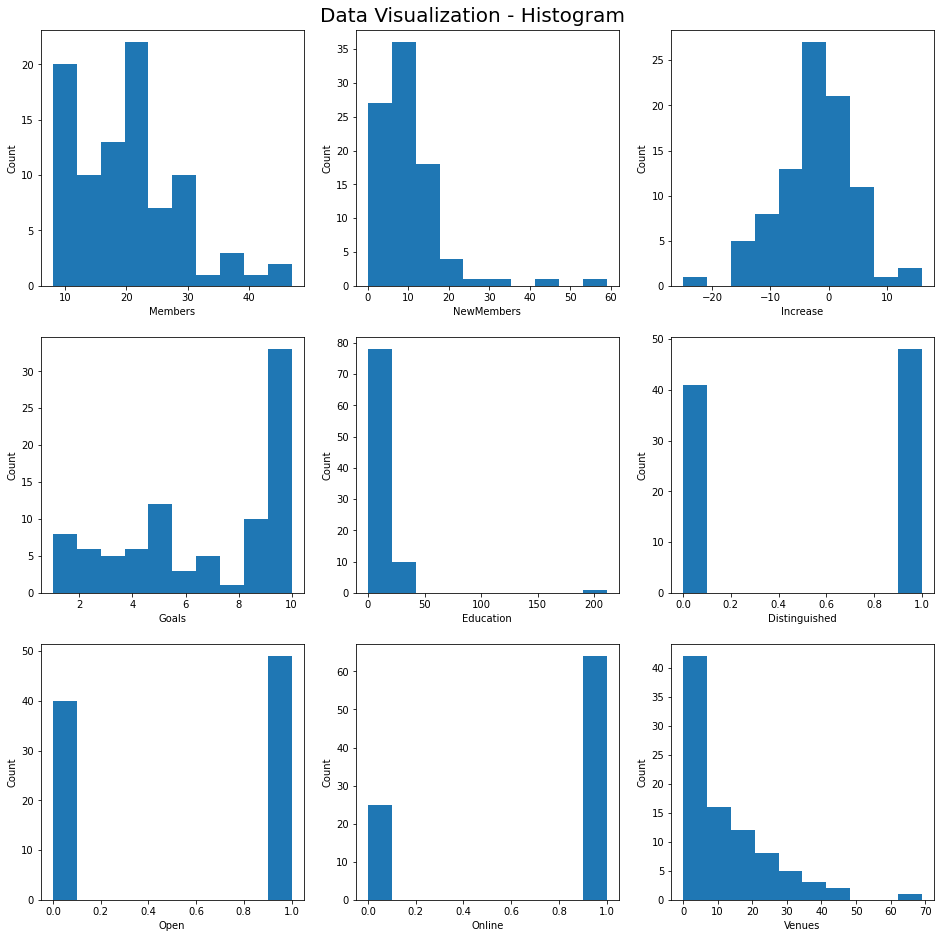

In [28]:
features_hist = ['Members', 'NewMembers', 'Increase', 'Goals', 'Education', 'Distinguished', 'Open', 'Online', 'Venues']

fig, ax = plt.subplots(3, 3, figsize=(16, 16))
fig.suptitle('Data Visualization - Histogram', y = 0.9, fontsize = 20)

for i in range(9):
    df_clubs[features_hist[i]].plot.hist(ax = ax[i // 3, i % 3])
    ax[i // 3, i % 3].set(xlabel = features_hist[i], ylabel = 'Count')

### Data Visualization - Box Plots

Box plots are used to visualize the spread and range of data.

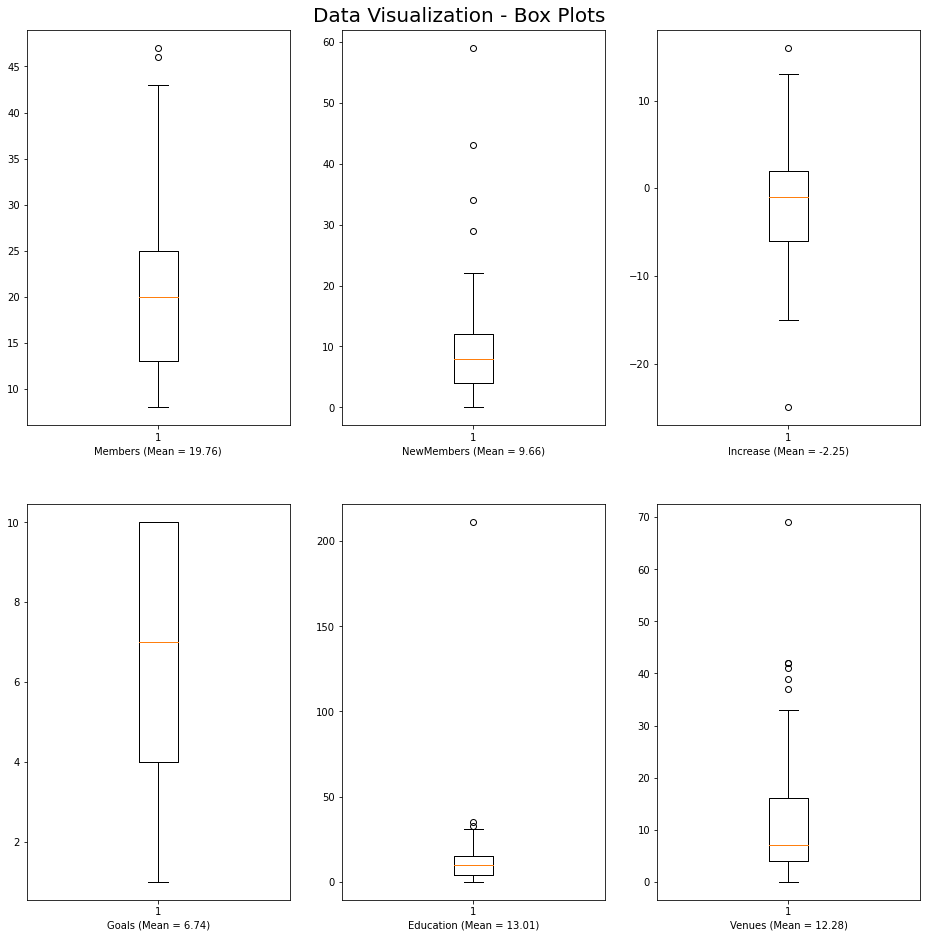

In [29]:
features_box = ['Members', 'NewMembers', 'Increase', 'Goals', 'Education', 'Venues']

fig, ax = plt.subplots(2, 3, figsize=(16, 16))
fig.suptitle('Data Visualization - Box Plots', y = 0.9, fontsize = 20)

for i in range(6):
    ax[i // 3, i % 3].boxplot(df_clubs[features_box[i]])
    ax[i // 3, i % 3].set(xlabel = f'{features_box[i]} (Mean = {df_clubs[features_box[i]].mean():.2f})')

## 4. Feature Selection, Model Training & Evaluation

Should we use the complete feature set to train the model? Or should we remove some variables from the set?

We will try to build the model using k-means algorithm for each possibility. First, we loop k from 2 through 10. Then, the sum of squared errors (SSE) is calculated. Next, the elbow method is used to determine the best k. Lastly, Silhouette analysis is used to validate the clusters generated.

**Why K-Means?**

The k-means algorithm is used because it is simple to implement, it can scale to large dataset, and it guarantees convergence. Its weakness of having to find the best k (number of clusters) can be mitigated by using the elbow method and Silhouette analysis.

From the results, then we make a sensible decision on the feature set, as well as the best k to use.

### Option 1 - Complete Feature Set

In [30]:
Features = all_features[:]
Features

['Members',
 'NewMembers',
 'Increase',
 'Goals',
 'Education',
 'Distinguished',
 'Open',
 'Online',
 'Venues',
 'Latitude',
 'Longitude']

In [31]:
scaled_features = StandardScaler().fit_transform(df_clubs[Features])

In [32]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

# A list holds the SSE values for each k
sse = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    
sse

[742.346249115297,
 654.922017550344,
 583.8119733503772,
 547.164083110308,
 508.77099586162666,
 472.9563082323474,
 451.40307113549295,
 424.83837314929275,
 401.27057011192966]

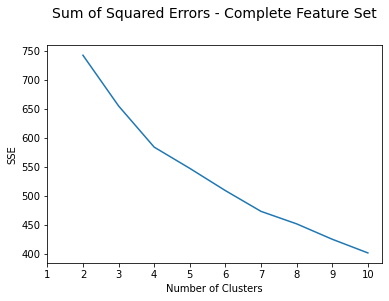

In [33]:
plt.plot(range(2, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors - Complete Feature Set', y = 1.1, fontsize = 14)
plt.show()

In [34]:
kl = KneeLocator(
   range(2, 11), sse, curve="convex", direction="decreasing"
   )

kl.elbow

4

In [35]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.23939607853396055,
 0.2390296071930531,
 0.2060133272990593,
 0.1624746063641717,
 0.13139197971726263,
 0.14180108658905585,
 0.17324844688617466,
 0.13704726640455683,
 0.13302253990580237]

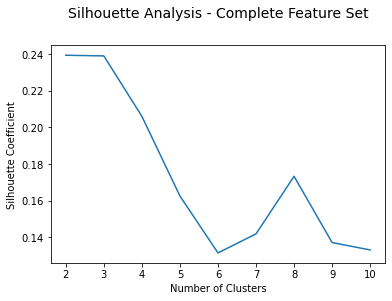

In [36]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Analysis - Complete Feature Set', y = 1.1, fontsize = 14)
plt.show()

**Evaluation** - The best number of clusters (k) is 4 but its Silhouette coefficient is not the best in graph above.

### Option 2 - Without Categorical Variables

Let's remove the 3 categorical variables from the feature set.
- "Distinguished" is removed because it is highly correlated to "Members" and "Goals", according to correlation analysis above. The nature of a distinguished club might already be well-explained by these variables.
- "Open" and "Online" are removed because they are not significant against some other variables, according to ANOVA analysis above.

In [37]:
Features.remove('Distinguished')
Features.remove('Open')
Features.remove('Online')
Features

['Members',
 'NewMembers',
 'Increase',
 'Goals',
 'Education',
 'Venues',
 'Latitude',
 'Longitude']

In [38]:
scaled_features = StandardScaler().fit_transform(df_clubs[Features])

In [39]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

# A list holds the SSE values for each k
sse = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    
sse

[571.4932335907553,
 507.6936030287319,
 439.56212667804,
 379.65403561927576,
 345.83486576523904,
 326.64675856788347,
 290.4712264194757,
 279.03340386811453,
 256.29230444041207]

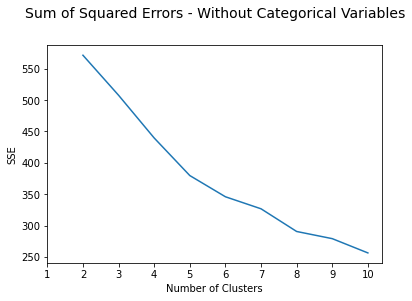

In [40]:
plt.plot(range(2, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors - Without Categorical Variables', y = 1.1, fontsize = 14)
plt.show()

In [41]:
kl = KneeLocator(
   range(2, 11), sse, curve="convex", direction="decreasing"
   )

kl.elbow

5

In [42]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.2018585097563179,
 0.19315784565972302,
 0.169721940585133,
 0.1762446740733649,
 0.16693888712652888,
 0.17036718515124527,
 0.18962625973580177,
 0.170655563037409,
 0.17746471871857925]

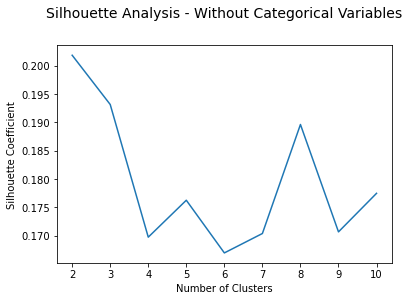

In [43]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Analysis - Without Categorical Variables', y = 1.1, fontsize = 14)
plt.show()

**Evaluation** - The best number of clusters (k) is 6 but its Silhouette coefficient is not the best in graph above.

### Option 3 - Minimum Feature Set

How about we reexamine the feature set, remove variables that can already be explained by other variables, in order to come up with the minimum set of features?

These variables are suggested to be removed:
- NewMembers: The number of new members could already be explained by the current number of members (Members).
- Increase: The net increase of membership could already be explained by the current number of members (Members).
- Education: The educational awards achieved by members could already be explained by the number of goals achieved (Goals).

In [44]:
Features.remove('NewMembers')
Features.remove('Increase')
Features.remove('Education')
Features

['Members', 'Goals', 'Venues', 'Latitude', 'Longitude']

In [45]:
scaled_features = StandardScaler().fit_transform(df_clubs[Features])

In [46]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

# A list holds the SSE values for each k
sse = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    
sse

[343.72916554846904,
 274.21608794043783,
 234.20897391595423,
 205.0276782535652,
 187.17399992810195,
 165.3591641123591,
 155.15305735619734,
 139.88955616611418,
 124.77717586738868]

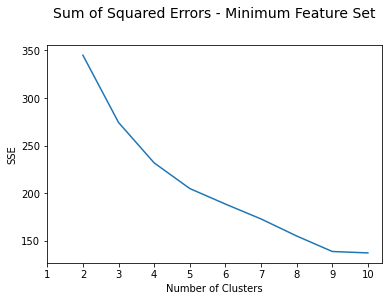

In [216]:
plt.plot(range(2, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors - Minimum Feature Set', y = 1.1, fontsize = 14)
plt.show()

In [47]:
kl = KneeLocator(
   range(2, 11), sse, curve="convex", direction="decreasing"
   )

kl.elbow

5

In [48]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.23322607945411788,
 0.25473875694011633,
 0.2438685425668602,
 0.26190687250158434,
 0.24015382193666915,
 0.26870931262021536,
 0.25719514465527077,
 0.24406446010165506,
 0.24501861458344518]

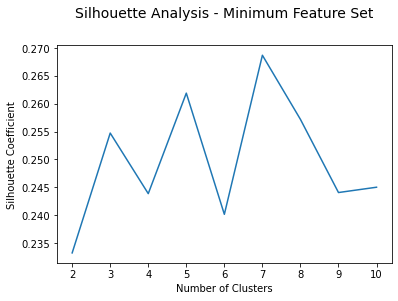

In [50]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Analysis - Minimum Feature Set', y = 1.1, fontsize = 14)
plt.show()

**Evaluation** - The best number of clusters (k) is 5 and its Silhouette coefficient looks good in graph above.

### Model Training

Option 3 looks good so the minimum set of features below will be used as the feature set to train the model.

In [51]:
Features

['Members', 'Goals', 'Venues', 'Latitude', 'Longitude']

In [52]:
# set number of clusters
kclusters = kl.elbow

kmeans = KMeans(n_clusters = kclusters, **kmeans_kwargs)
kmeans.fit(scaled_features)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_ + 1
labels

array([1, 1, 2, 2, 2, 1, 2, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 2, 1, 4, 2, 5,
       5, 2, 5, 2, 1, 5, 1, 2, 1, 2, 5, 2, 2, 2, 5, 5, 2, 5, 1, 2, 5, 2,
       5, 5, 1, 5, 1, 1, 2, 2, 2, 5, 1, 5, 1, 1, 5, 5, 5, 5, 1, 5, 5, 1,
       1, 1, 2, 1, 4, 4, 4, 2, 2, 2, 5, 3, 3, 4, 2, 4, 3, 3, 3, 3, 3, 4,
       4])

Insert Cluster into dataset and sort data by cluster and club name.

In [53]:
df_clubs.insert(0, 'Cluster', labels)
df_clubs.sort_values(by = ['Cluster', 'ClubName'], inplace = True)
df_clubs.head()

,Cluster,ClubName,Members,NewMembers,Increase,Goals,Education,Distinguished,Open,Online,Venues,Latitude,Longitude
ClubNum,,,,,,,,,,,,,
2845164,1,Apple Mentors Toastmasters Club,18,12,5,10,22,1,1,1,26,3.100530,101.645790
3983,1,CIMA Malaysia Toastmasters Club,22,9,-1,10,10,1,0,1,39,3.146923,101.615763
4818898,1,Damansara Toastmasters Club,10,7,-6,4,1,0,1,1,32,3.135110,101.621170
3128304,1,Gamuda Toastmasters Club,26,15,4,10,22,1,0,0,23,3.168073,101.613133
6933561,1,HILTI ASIA IT SERVICES,27,8,-1,7,11,1,0,1,25,3.113339,101.575445


Get and plot the number of clubs in each cluster.

In [54]:
df_plot = pd.DataFrame(df_clubs['Cluster'].value_counts(sort = False))
df_plot.index.name = 'Cluster'
df_plot.columns = ['Count']
df_plot

,Count
Cluster,
1,19
2,25
3,8
4,8
5,29


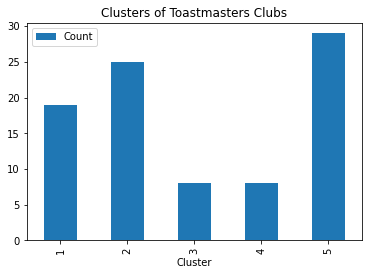

In [55]:
df_plot.plot.bar(title = 'Clusters of Toastmasters Clubs')

Visualize the clusters on map using Folium library.

In [56]:
# create map
map_clubs = folium.Map(location = [clubs_latitude, clubs_longitude], zoom_start = 10)
map_clubs.get_root().html.add_child(folium.Element('<h3 align="center">Toastmasters Clubs in Selangor, Malaysia</h3>'))

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, clubnum, clubname, cluster in zip(df_clubs['Latitude'], df_clubs['Longitude'], df_clubs.index, df_clubs['ClubName'], df_clubs['Cluster']):
    label = folium.Popup(f'Cluster {str(cluster)} {str(clubnum)} {clubname}', parse_html = True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9
    ).add_to(map_clubs)
       
map_clubs

Can't see the map above? Try [https://nbviewer.jupyter.org/github/rickysoo/clustering-toastmasters/blob/master/Clustering-Toastmasters.ipynb](https://nbviewer.jupyter.org/github/rickysoo/clustering-toastmasters/blob/master/Clustering-Toastmasters.ipynb)

## 5. Results

Here we look at each cluster and the clubs to attempt to interpret and explain the clusters.

### Club Listing

In [57]:
# Group clubs by clusters
grouped_clusters = df_clubs.groupby('Cluster')

In [58]:
# Print all clubs in each cluster
for cluster in range(1, kclusters + 1):
    print(f'Cluster {cluster} ({len(grouped_clusters.get_group(cluster))} clubs)')
    print()
    print(grouped_clusters.get_group(cluster)[['ClubName']])
    print('---------')
    print()

Cluster 1 (19 clubs)

                                                ClubName
ClubNum                                                 
2845164                  Apple Mentors Toastmasters Club
3983                     CIMA Malaysia Toastmasters Club
4818898                      Damansara Toastmasters Club
3128304                         Gamuda Toastmasters Club
6933561                           HILTI ASIA IT SERVICES
6812744           Kelab Pidato Perdana Toastmasters Club
6430231  MDA Kuala Lumpur and Selangor Toastmasters Club
9004                           MIM Club of Petaling Jaya
4644596                     MY Puchong Toastmasters Club
7208725               Nielsen Malaysia Toastmasters Club
7350068                                Novartis Malaysia
989051                         Phoenix Toastmasters Club
680290                 Puchong English Toastmasters Club
7077648                 S&P Industries Toastmasters Club
693895           School Of Hard Knocks Toastmasters Club
1517575  

### Descriptive Statistics

In [59]:
# Descriptive statistics of each cluster
for cluster in range(1, kclusters + 1):
    print(f'Cluster {cluster} ({len(grouped_clusters.get_group(cluster))} clubs)')
    print()
    print(grouped_clusters.get_group(cluster).describe())
    print('---------')
    print()

Cluster 1 (19 clubs)

       Cluster    Members  NewMembers   Increase      Goals  Education  \
count     19.0  19.000000   19.000000  19.000000  19.000000  19.000000   
mean       1.0  19.736842    9.210526  -0.526316   7.210526  12.105263   
std        0.0   6.894781    4.673554   5.305850   2.954826   8.372539   
min        1.0   8.000000    0.000000 -13.000000   1.000000   1.000000   
25%        1.0  15.500000    5.500000  -2.000000   5.000000   6.500000   
50%        1.0  19.000000    9.000000   0.000000   7.000000  11.000000   
75%        1.0  24.000000   12.500000   3.500000  10.000000  15.500000   
max        1.0  36.000000   17.000000   6.000000  10.000000  33.000000   

       Distinguished       Open     Online     Venues   Latitude   Longitude  
count      19.000000  19.000000  19.000000  19.000000  19.000000   19.000000  
mean        0.631579   0.526316   0.684211  32.157895   3.101789  101.617014  
std         0.495595   0.512989   0.477567  11.533830   0.041276    0.0212

### Visualization of Clusters

We use box plots to visualize the clusters according to each variable in the feature set.

For comparison purpose, the distribution of ALL clubs is shown on the right-hand side.

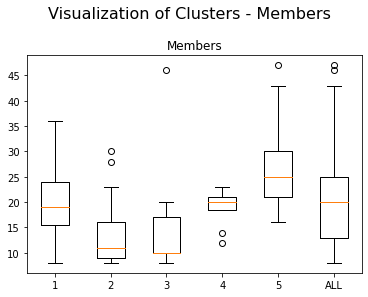

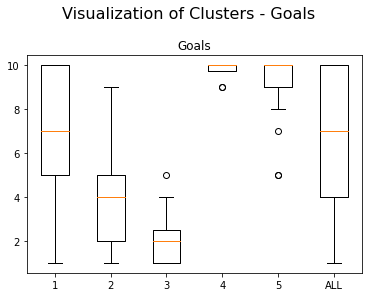

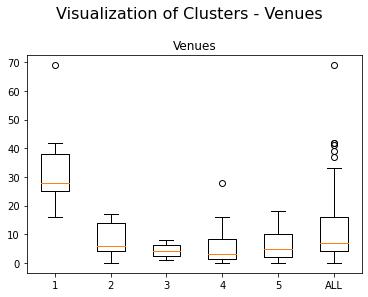

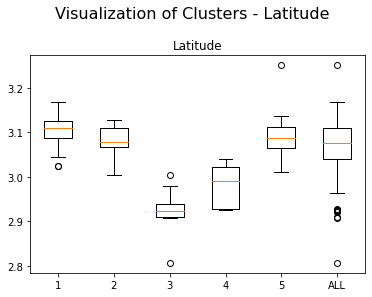

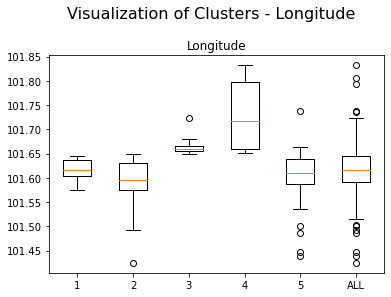

In [60]:
for feature in Features:
    data = [grouped_clusters.get_group(cluster)[feature] for cluster in range(1, kclusters + 1)]
    data.append(df_clubs[feature])

    fig, ax = plt.subplots()
    fig.suptitle('Visualization of Clusters - ' + feature, y = 1.05, fontsize = 16)
    
    ax.set_title(feature)
    ax.boxplot(data, labels = list(range(1, kclusters + 1)) + ['ALL'])

### Explanation of Box Plots

**Members** - Cluster 1 and 4 tend to have average number of members. Cluster 2 and 3 are below average, while Cluster 5 is above average.

**Goals** - Cluster 1 tend to average number of club goals. Cluster 2 and 3 tend to have below average. Cluster 4 and 5 tend to have above average. In the last group, the medians are 10, meaning that at least half of the clubs in Cluster 4 and 5 achieve perfect 10 out of 10 goals.

**Venues** - Cluster 1 has tend to have than double the average number of popular venues within walking distance of club locations. The other clusters tend to have average number of such venues.

**Latitude** - Cluster 3 followed by Cluster 4 tend to lie toward the southern part of Selangor state.

**Longitude** - Cluster 4 followed by Cluster 3 tend to lie toward the eastern part of Selangor state.

### Interpretation of Clusters

**Cluster 1 (19 clubs)** - These clubs tend to have average number of members and goals achieved, but tend to high number of popular venues around them.

**Cluster 2 (25 clubs)** - These clubs tend to have number of members and goals achieved below the averages.

**Cluster 3 (8 clubs)** - These clubs tend to have number of members and goals achieved below the averages. They are located more toward the southern part of Selangor state.

**Cluster 4 (8 clubs)** - These clubs tend to have average number of members but above-average goals achieved. They are located more toward the south-eastern part of Selangor state.

**Cluster 5 (29 clubs)** - These clubs tend to have above-average number of members and goals achieved.

In [160]:
df_clubs.to_excel('clubs_clusters.xlsx', index = True)

This project is completed as the capstone project for the Applied Data Science Capstone course on Coursera at https://www.coursera.org/learn/applied-data-science-capstone, which is the final course for the IBM Data Science Professional Certificate course at https://www.coursera.org/professional-certificates/ibm-data-science

For a more complete elaboration of this project, refer to the full report at [https://github.com/rickysoo/clustering-toastmasters/blob/master/report.pdf](https://github.com/rickysoo/clustering-toastmasters/blob/master/report.pdf)